In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('retina')
import sys, os, time, glob
from slab import dsfit, dataanalysis
sys.path.append(r"S:\_Data\170422 - EonHe M018V6 with L3 etch")
from modules.Common import common
from experiment.data_cache import dataCacheProxy
from tqdm import tqdm
import scipy
print scipy.__version__
from mpltools import color
from scipy.interpolate import interp1d
from scipy import signal

0.15.1


In [2]:
def get_f0s(fpts, mags, span=2E6):
    f0s, Qs = list(), list()

    for k in tqdm(range(np.shape(mags)[0])):
        center_freq = fpts[k, np.argmax(mags[k,:])]
        try:
            fr = dsfit.fitlor(fpts[k,:], dataanalysis.dBm_to_W(mags[k,:]), 
                              domain=[center_freq-span/2., center_freq+span/2.])
            f0s.append(fr[2])
            Qs.append(fr[2]/(2*fr[3]))
        except:
            print "Fit failed!" 
            f0s.append(np.nan)
            Qs.append(np.nan)
        
    return f0s, Qs

def rgba(i, N, cmap=plt.cm.plasma):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=N)
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    return m.to_rgba(i)

def Vtrap_separated(Vrg, mu):
    f_mu = -1.755-7*mu
    return (f_mu-0.120) - 1.15*Vrg

def Vrg_separated(Vtrap, mu):
    f_mu = -1.755-7*mu
    return -1/1.15*(Vtrap+(0.120-f_mu))
    
def Vtrap_avalanche(mu):
    return -0.120 - 1.69*mu

def Vrg_iso(contour=0.020):
    if contour >= 0.010:
        return 1/1.15 * (-0.22-0.32-10*contour) * 1/(1 + 1/1.15)
    else:
        return np.nan
    
def construct_line(x, point1, point2, verbose=False):
    x1, y1 = point1
    x2, y2 = point2
    slope = (y2-y1)/(x2-x1)
    if verbose:
        print "y = %.3f x + %.3f"%(slope, y1-slope*x1)
    return slope*(x-x1) + y1

def get_slope(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return (y2-y1)/(x2-x1)

def get_line_params(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    slope = (y2-y1)/(x2-x1)
    offset = y1-slope*x1
    return offset, slope

def get_isct_pt(line1_params, line2_params):
    a0, a1 = line1_params # offset, slope
    b0, b1 = line2_params
    xi = (b0-a0)/(a1-b1)
    yi = a1 * xi + a0
    return xi, yi

def f(p, x):
    return (p[0] + np.arctan((p[1]-x)/p[2]))*180/np.pi

def g(p, x):
    return (p[0]+p[1]/(1+(x-p[2])**2/p[3]**2))

# Run from here

['170805_165624_diagonal_sweep' '170805_174649_diagonal_sweep'
 '170805_182436_diagonal_sweep' '170805_190228_diagonal_sweep'
 '170805_194022_diagonal_sweep' '170805_201820_diagonal_sweep'
 '170805_205620_diagonal_sweep' '170805_213422_diagonal_sweep'
 '170805_221229_diagonal_sweep' '170805_225039_diagonal_sweep'
 '170805_232853_diagonal_sweep' '170806_000709_diagonal_sweep']


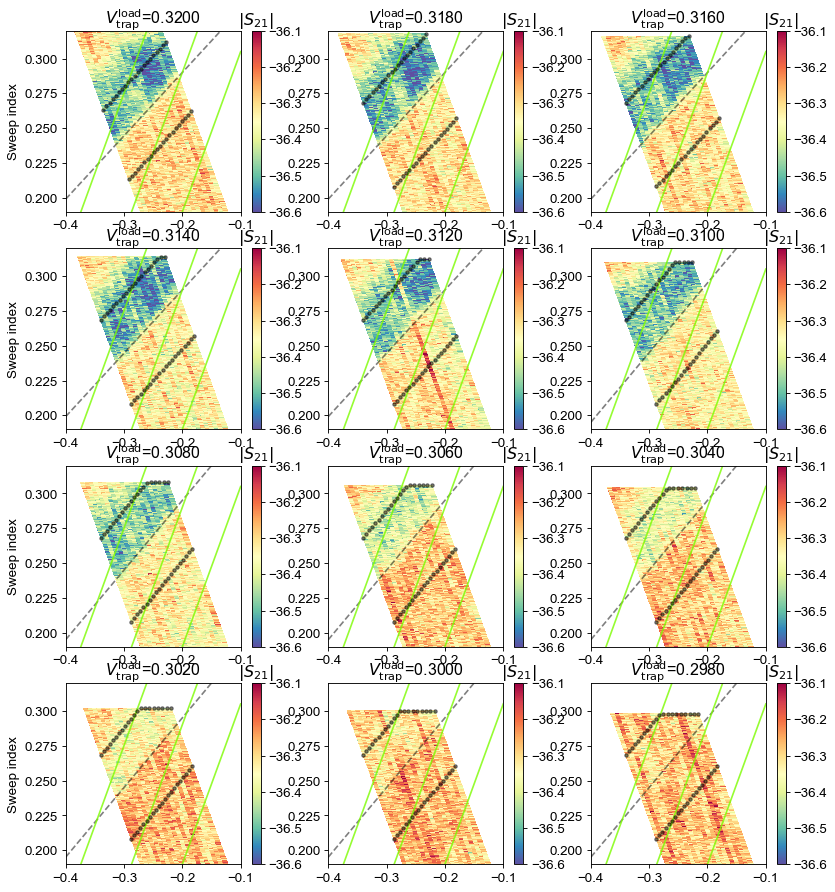

In [21]:
dirs = glob.glob(r"*diagonal_sweep*")
print np.sort(dirs)

fig = plt.figure(figsize=(12.,21.))
clims = (-36.6, -36.1)

do_imshow=False
metric1, metric2 = list(), list()
Vtraploads = list()
first_part_mags = list()
first_part_phases = list()
first_parts_axis = list()

for i, foldername in tqdm(enumerate(np.sort(dirs))):
    filename = os.path.join(os.getcwd(), foldername, foldername+".h5")
    d = dataCacheProxy(file_path=filename)
    
    fast_mags = d.get('fast_mags')
    fast_phases = d.get('fast_phases')
    fast_sweep_points = d.get('fast_sweep_points')
    fast_sweep_voltage_axis1 = d.get('sweep_voltage_1')
    fast_sweep_voltage_axis2 = d.get('sweep_voltage_2')
    Vtrapload = np.max(fast_sweep_voltage_axis2)
    
    first_parts_axis.append(fast_sweep_voltage_axis1[-1, :np.argmin(fast_sweep_voltage_axis1[-1, :])])
    first_part_mags.append(fast_mags[0, :np.argmin(fast_sweep_voltage_axis1[-1, :])])
    first_part_phases.append(fast_phases[0, :np.argmin(fast_sweep_voltage_axis1[-1, :])])
    
    plt.subplot(6, 3, i+1)
    plt.title("$V_\mathrm{trap}^\mathrm{load}$=%.4f"%(Vtrapload))
    if do_imshow:
        plt.imshow(fast_mags, aspect='auto', cmap=plt.cm.Spectral_r, interpolation='none', origin='lower')
        plt.vlines(fast_sweep_points[0,0], 0, np.shape(fast_mags)[0]-1, linestyles='--', alpha=0.5)
    else:
        appropriate_idcs = np.arange(0, np.shape(fast_mags)[0])
        axis1 = fast_sweep_voltage_axis1[appropriate_idcs.astype(int),:]
        axis2 =  fast_sweep_voltage_axis2[appropriate_idcs.astype(int),:]

        plt.pcolormesh(axis1, axis2, fast_mags, cmap=plt.cm.Spectral_r)
        plt.xlim(-0.4, -0.1)
        plt.ylim(0.19, 0.32)
        
        x = np.linspace(-0.4, -0.1)
        if i < 5:
            pt1 = (-0.310, 0.24)
            pt2 = (-0.200, 0.29)
        elif i >=5:
            pt1 = (-0.310, 0.240)
            pt2 = (-0.210, 0.290)
        else:
            pt1 = (-0.38, 0.22)
            pt2 = (-0.25, 0.25)
        
        if i >= 0:
            plt.plot(x, construct_line(x, pt1, pt2), '--', color='k', alpha=0.5)
            for iso in np.arange(0.030, 0.000, -0.010):
                plt.plot(x, 0.32 + 10*iso + 1.15*x, '-', color='lawngreen', alpha=0.8)
            
            # Extract the metric
            metric1.append(get_slope(pt1, pt2))
            
            z = fast_mags[:, fast_sweep_points[0,0]:]
            x = axis1[:, fast_sweep_points[0,0]:]
            y = axis2[:, fast_sweep_points[0,0]:]

            metric_below = list()
            metric_above = list()
            
            avg_range = 100

            for k in range(np.shape(z)[0]):
                xi, yi = get_isct_pt(get_line_params(pt1, pt2), get_line_params((x[k,0], y[k,0]), (x[k,-1], y[k,-1])))
                xi_idx = common.find_nearest(x[k, :], xi)
                bot_idx = np.max([xi_idx-avg_range, 0])
                top_idx = np.min([xi_idx+avg_range, len(z[k, :])-1])
                metric_below.append(np.mean(z[k, bot_idx:xi_idx]))
                metric_above.append(np.mean(z[k, xi_idx:top_idx]))
                plt.plot(x[k, bot_idx], y[k, bot_idx], '.k', alpha=0.5)
                plt.plot(x[k, top_idx], y[k, top_idx], '.k', alpha=0.5)
                
            Vtraploads.append(Vtrapload)
            metric2.append(np.mean(metric_above)-np.mean(metric_below))
    
    if clims is not None:
        plt.clim(clims)
    cbar = plt.colorbar()
    cbar.ax.set_title('$|S_{21}|$')
    
    if not(i%3):
        plt.ylabel("Sweep index")
    if i>14:
        plt.xlabel("Time points")
        
# common.save_figure(fig, save_path=os.getcwd())

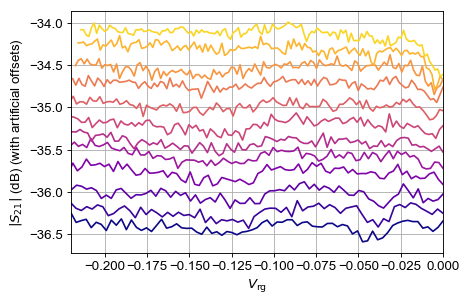

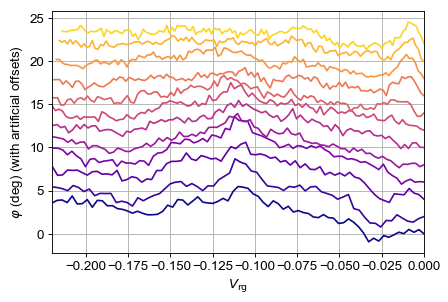

In [31]:
fig = plt.figure(figsize=(6.,4.))
common.configure_axes(12)
for k in range(len(first_part_mags)):
    plt.plot(first_parts_axis[k], first_part_mags[k] + k*0.2, color=rgba(k, len(first_parts_axis)))
plt.xlabel("$V_\mathrm{rg}$")
plt.ylabel(r"$|S_{21}|$ (dB) (with artificial offsets)")
plt.xlim(-0.22, 0.00)
plt.grid()
# common.save_figure(fig, save_path=os.getcwd())
    
fig = plt.figure(figsize=(6.,4.))
common.configure_axes(12)
for k in range(len(first_part_phases)):
    plt.plot(first_parts_axis[k], first_part_phases[k] - first_part_phases[k][0] + k*2, color=rgba(k, len(first_parts_axis)))
plt.xlabel("$V_\mathrm{rg}$")
plt.ylabel(r"$\varphi$ (deg) (with artificial offsets)")
plt.xlim(-0.22, 0.00)
plt.grid()
# common.save_figure(fig, save_path=os.getcwd())

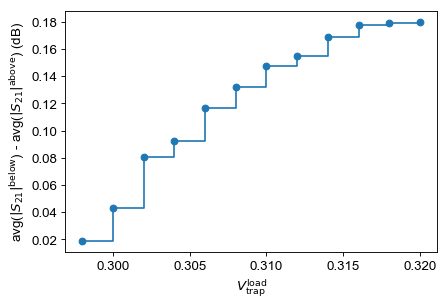

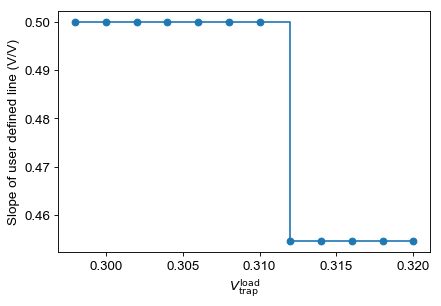

In [27]:
fig = plt.figure(figsize=(6.,4.))
common.configure_axes(12)
plt.step(Vtraploads, metric2, 'o')
plt.xlabel("$V_\mathrm{trap}^\mathrm{load}$")
plt.ylabel(r"avg($|S_{21}|^\mathrm{below}$) - avg($|S_{21}|^\mathrm{above}$) (dB)")

# common.save_figure(fig, save_path=os.getcwd())

fig = plt.figure(figsize=(6.,4.))
common.configure_axes(12)
plt.step(Vtraploads, metric1, 'o')
plt.xlabel("$V_\mathrm{trap}^\mathrm{load}$")
plt.ylabel(r"Slope of user defined line (V/V)")

# common.save_figure(fig, save_path=os.getcwd())

-0.00606402086114


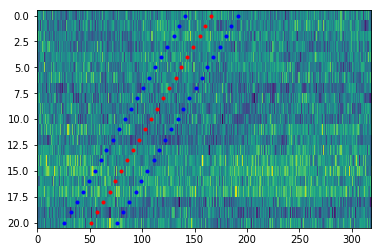

In [63]:
plt.imshow(fast_mags[:, fast_sweep_points[0,0]:], aspect='auto')
z = fast_mags[:, fast_sweep_points[0,0]:]
x = axis1[:, fast_sweep_points[0,0]:]
y = axis2[:, fast_sweep_points[0,0]:]

metric = list()
avg_range = 25

for k in range(np.shape(z)[0]):
    xi, yi = get_isct_pt(get_line_params(pt1, pt2), get_line_params((x[k,0], y[k,0]), (x[k,-1], y[k,-1])))
#     print xi, yi
    xi_idx = common.find_nearest(x[k, :], xi)
    plt.plot(xi_idx, k, '.r')
    plt.plot(xi_idx-avg_range, k, '.b')
    plt.plot(xi_idx+avg_range, k, '.b')

    metric.append(np.mean(z[k, xi_idx:xi_idx+avg_range]) - np.mean(z[k, xi_idx-avg_range:xi_idx]))

print np.mean(metric)